In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
import sys, collections
from scipy.stats import gaussian_kde

In [3]:
#load human_mouse transcripts

tr2g = {}
trlist = []
with open('../index/tr2g_human_mouse') as f:
    for line in f:
        l = line.split()
        tr2g[l[0]] = l[1]
        trlist.append(l[0])

genes = list(set(tr2g[t] for t in tr2g))

# load equivalence classes
ecs = {}
with open('../kallisto_hgmm6k_out/matrix.ec') as f:
    for line in f:
        l = line.split()
        ec = int(l[0])
        trs = [int(x) for x in l[1].split(',')]
        ecs[ec] = trs
        
def ec2g(ec):
    if ec in ecs:
        return list(set(tr2g[trlist[t]] for t in ecs[ec]))        
    else:
        return []

In [4]:
# load test dataset

cell_gene = collections.defaultdict(lambda: collections.defaultdict(float))
pbar=None
pumi=None
with open('../kallisto_hgmm6k_out/output.sort.txt') as f:
    gs = set()
    for line in f:
        l = line.split()
        barcode,umi,ec,count = line.split()
        ec = int(ec)
        
        if barcode == pbar:
            # same barcode
            if umi == pumi:
                # same UMI, let's update with intersection of genelist
                gl = ec2g(ec)
                gs.intersection_update(gl)
            else:
                # new UMI, process the previous gene set
                for g in gs:
                    cell_gene[barcode][g] += 1.0/len(gs)
                # record new umi, reset gene set
                pumi = umi
                gs = set(ec2g(ec))
        else:
            # work with previous gene list
            for g in gs:
                cell_gene[pbar][g] += 1.0/len(gs)
            
            if sum(cell_gene[pbar][g] for g in cell_gene[pbar]) < 10:
                del cell_gene[pbar]
            
            pbar = barcode
            pumi = umi
            
            gs = set(ec2g(ec))
    #remember the last gene
    for g in gs:
        cell_gene[pbar][g] += 1.0/len(gs)
        
    if sum(cell_gene[pbar][g] for g in cell_gene[pbar]) < 10:
        del cell_gene[pbar]



In [5]:
barcode_hist = collections.defaultdict(int)
for barcode in cell_gene:
    cg = cell_gene[barcode]
    s = len([cg[g] for g in cg])
    barcode_hist[barcode] += s
    

381651


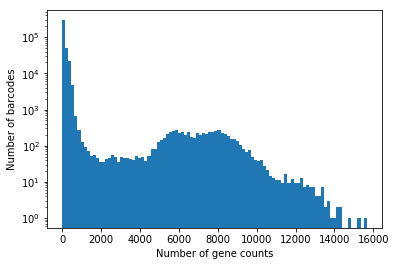

In [6]:
bcv = [x for b,x in barcode_hist.items() if x > 0]
_ = plt.hist(bcv,bins=100, log=True)
plt.rcParams["figure.figsize"] = [9,6]
plt.xlabel("Number of gene counts")
plt.ylabel("Number of barcodes")
print(len(bcv))

In [7]:
bad_barcode = [x for x in barcode_hist if  barcode_hist[x] <= 2000]
len(bad_barcode)/len(cell_gene)

0.9812289238073528

In [8]:
s = 0
bad_s = 0
bad_barcode_set = set(bad_barcode)
for barcode in cell_gene:
    cg = cell_gene[barcode]
    cgs =  sum(cg[g] for g in cg)
    s += cgs
    if barcode in bad_barcode_set:
        bad_s += cgs
    

In [9]:
bad_s/s

0.1230835559526919

In [10]:
outfile = '../kallisto_hgmm6k_out/matrix.mtx'

gene_to_id = dict((g,i+1) for i,g in enumerate(genes))
barcodes_to_use = [b for b,x in barcode_hist.items() if x > 2000 and x < 10000]

num_entries = 0
for barcode in barcodes_to_use:
    num_entries += len([x for x in cell_gene[barcode].values() if round(x)>0])



In [11]:
with open(outfile, 'w') as of:
    of.write('%%MatrixMarket matrix coordinate real general\n%\n')
    #number of genes
    of.write("%d %d %d\n"%(len(genes), len(barcodes_to_use), num_entries))
    bcid = 0
    for barcode in barcodes_to_use:
        bcid += 1
        cg = cell_gene[barcode]
        gl = [(gene_to_id[g],round(cg[g])) for g in cg if round(cg[g]) > 0]
        gl.sort()
        for x in gl:
            of.write("%d %d %d\n"%(x[0],bcid,x[1]))
    

In [12]:
gene_names = {}
with open('../index/mart_export_human_mouse.txt') as f:
    f.readline()
    for line in f:
        g,t,gn = line.split()
        gene_names[g] = gn


In [13]:
id_to_genes = dict((i,g) for (g,i) in gene_to_id.items())
gl = []
for i in range(1,len(genes)+1):
    g = id_to_genes[i]
    gid = g[:g.find('.')]
    if gid in gene_names:
        gn = gene_names[gid]
    else:
        gn = ''
    gl.append((g,gn))

with open('../kallisto_hgmm6k_out/genes.tsv','w') as of:
    for g,gn in gl:
        of.write("%s\t%s\n"%(g,gn))
        
with open('../kallisto_hgmm6k_out/barcodes.tsv','w') as of:
    of.write('\n'.join(x + '-1' for x in barcodes_to_use))
    of.write('\n')

# Load 10XG style gene count data

In [14]:
import numpy as np
import pandas as pd
import scanpy.api as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = '../kallisto_hgmm6k_out/hgmm6k.h5ad'
sc.settings.set_figure_params(dpi=80)

adata = sc.read_10x_mtx('../kallisto_hgmm6k_out/', var_names='gene_ids', cache=False)
adata.var_names_make_unique()

scanpy==1.3.2 anndata==0.6.10 numpy==1.15.1 scipy==1.1.0 pandas==0.23.0 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


# Get gene counts for human genes and mouse genes for each cell barcode

In [15]:
human_genes = [name for name in adata.var_names if name.startswith('ENSG')]
mouse_genes = [name for name in adata.var_names if name.startswith('ENSMUSG')]
# for each cell compute counts in human genes and mouse genes
# the `.A1` is only necessary as X is sparse to transform to a dense array after summing
adata.obs['counts_human'] = np.sum(adata[:, human_genes].X, axis=1).A1
adata.obs['counts_mouse'] = np.sum(adata[:, mouse_genes].X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['counts_total'] = adata.X.sum(axis=1).A1

# Check total number of cell barcodes

In [16]:
len(adata.obs)

6851

# Check number of cell barcodes with both human & mouse transcripts detected (at least 5% of total transcripts)

In [17]:
len(adata.obs[(adata.obs['counts_human']>adata.obs['counts_total']*0.05) & (adata.obs['counts_mouse']>adata.obs['counts_total']*0.05)])

117

# Generate scatterplot to show counts of human transcripts vs. counts of mouse transcripts for each cell barcode

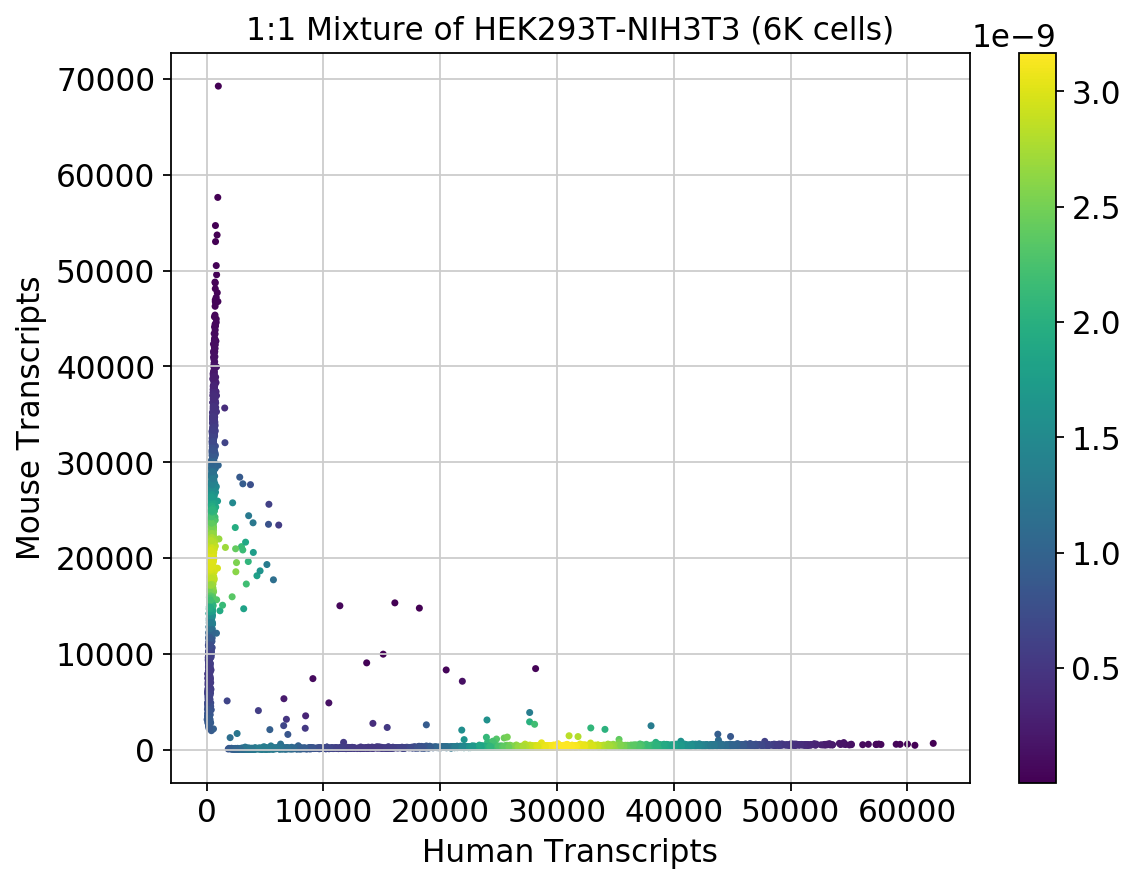

In [21]:
xy = np.vstack([adata.obs['counts_human'], adata.obs['counts_mouse']])
z = gaussian_kde(xy)(xy)
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(8,6))
plt.scatter(adata.obs['counts_human'], adata.obs['counts_mouse'], c=z, s=10, edgecolor='')
plt.title('1:1 Mixture of HEK293T-NIH3T3 (6K cells)')
plt.xlabel('Human Transcripts')
plt.ylabel('Mouse Transcripts')
plt.colorbar()

# Plot number of transcripts detected in human and mouse cells

Text(0,0.5,'Number of transcripts')

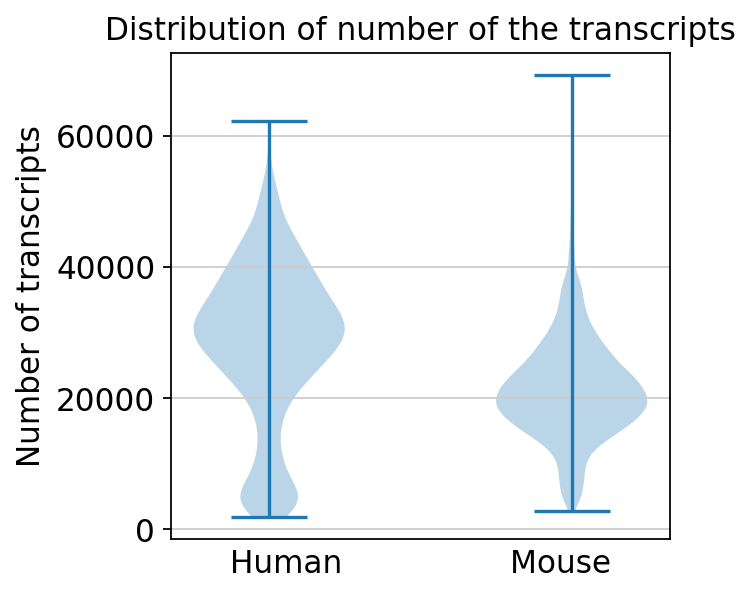

In [19]:
adata_mouse = adata.obs[(adata.obs['counts_human']<adata.obs['counts_total']*0.05)]
adata_human = adata.obs[(adata.obs['counts_mouse']<adata.obs['counts_total']*0.05)]
#len(adata_mouse['counts_mouse'])
#len(adata_human['counts_human'])
plt.violinplot(dataset = [adata_human[:]['counts_human'], adata_mouse[:]['counts_mouse']])
plt.title('Distribution of number of the transcripts')
plt.xticks([])
plt.xlabel('Human                 Mouse')
plt.ylabel('Number of transcripts')

In [20]:
adata.obs.to_csv('../comparison_hgmm6k/counts_kallisto.csv', sep=',')